# Circadian amplitude boost simulations

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from circadian.lights import LightSchedule
from circadian.models import Forger99, Jewett99, Hannay19, Hannay19TP
from circadian.utils import phase_difference, amplitude_percent_change

# St. Hilaire 12 light schedule (1 hr light pulse)

In [2]:
coarse_dt = 0.1 # hours
fine_dt = 0.05 # hours
model_list = [Forger99(), Jewett99(), Hannay19(), Hannay19TP()]

## Reference state

In [3]:
days = 21 # 3 weeks of regular schedule
time_eq = np.arange(0, 24 * days, coarse_dt)
schedule = LightSchedule.Regular(lights_on=8, lights_off=24)
light_input = schedule(time_eq)
equilibrium_states = []

for model in model_list:
    final_state = model.equilibrate(time_eq, light_input, num_loops=2)
    equilibrium_states.append(final_state)

## Constant routine variation

In [4]:
pulse_num = 100
pulse_duration = 1 # hour
min_CR1_duration = 26
max_CR1_duration = 65
second_constant_routine_duration = 20
reference_dlmo_idx = 6 # Closest DLMO to pulse
first_constant_routine_duration = np.linspace(min_CR1_duration, max_CR1_duration, pulse_num)

In [5]:
simulation_result = {
    'model_list': model_list,
    'pulse_num': pulse_num,
    'pulse_duration': pulse_duration,
    'first_constant_routine_duration': first_constant_routine_duration,
    }
trajectories = {}

for idx,model in tqdm(enumerate(model_list), desc='Models'):
    simulation_result[str(model)] = {
        'reference_dlmo': np.NaN,
        'phase_response': [],
        'amplitude_response': [],
        'model_list': model_list,
    }
    trajectories[str(model)] = {}
    for CR1_duration in tqdm(first_constant_routine_duration, desc='CR1 duration'):
        pulse_mid_time = 24*3 + 8 + CR1_duration + 8 + 8
        # create the reference trajectory
        control_schedule = LightSchedule.Hilaire12(CR1_duration, second_constant_routine_duration,
                                                   pulse_lux=3, pulse_duration=pulse_duration)
        control_time = np.arange(0, pulse_mid_time + 48, coarse_dt)
        control_light = control_schedule(control_time)
        control_trajectory = model(control_time, equilibrium_states[idx], control_light)
        # pulse trajectory
        pulse_schedule = LightSchedule.Hilaire12(CR1_duration, second_constant_routine_duration,
                                                 pulse_duration=pulse_duration)
        # first part of the simulation, from beginning until 2 hours before the pulse mid time (coarse time step)
        pulse_time_first_part = np.arange(0, pulse_mid_time - 2, coarse_dt)
        pulse_light_first_part = pulse_schedule(pulse_time_first_part)
        pulse_trajectory_first_part = model(pulse_time_first_part, equilibrium_states[idx], pulse_light_first_part)
        # second part of the simulation, close to the pulse (fine time step)
        pulse_time_second_part = np.arange(pulse_trajectory_first_part.time[-1], pulse_mid_time + 2, fine_dt)
        pulse_light_second_part = pulse_schedule(pulse_time_second_part)
        initial_condition = pulse_trajectory_first_part.states[-1, ...]
        pulse_trajectory_second_part = model(pulse_time_second_part, initial_condition, pulse_light_second_part)

        pulse_end_time = 24*3 + 8 + CR1_duration + 8 + 8 + 0.5 # Assuming 1 hour pulse

        control_phase = model.phase(control_trajectory, pulse_end_time)
        pulse_phase = model.phase(pulse_trajectory_second_part, pulse_end_time)
        phase_diff = phase_difference(control_phase, pulse_phase)
        simulation_result[str(model)]['phase_response'].append(phase_diff)

        control_amplitude = model.amplitude(control_trajectory, pulse_end_time)
        pulse_amplitude = model.amplitude(pulse_trajectory_second_part, pulse_end_time)
        amplitude_change = amplitude_percent_change(control_amplitude, pulse_amplitude)
        simulation_result[str(model)]['amplitude_response'].append(amplitude_change)

        control_dlmos = model.dlmos(control_trajectory)
        simulation_result[str(model)]['reference_dlmo'] = control_dlmos[reference_dlmo_idx]

        CR1_index = np.where(first_constant_routine_duration == CR1_duration)[0][0]
        trajectories[str(model)][str(CR1_index)] = {
            'control': control_trajectory,
            'pulse_first_part': pulse_trajectory_first_part,
            'pulse_second_part': pulse_trajectory_second_part,
            'light_first_part': pulse_light_first_part,
            'light_second_part': pulse_light_second_part,
            'control_dlmos': control_dlmos,
        }

# convert phase differences from radians to hours
period = 24.2 # hours
for model in model_list:
    phase_response = simulation_result[str(model)]['phase_response']
    phase_response = np.array(phase_response) * period / (2 * np.pi)
    simulation_result[str(model)]['phase_response'] = phase_response

Models: 0it [00:00, ?it/s]

CR1 duration:   0%|          | 0/100 [00:00<?, ?it/s]

CR1 duration:   0%|          | 0/100 [00:00<?, ?it/s]

c:\users\tavel\desktop\internship-arcascope\circadian\circadian\models.py:463: UserWarning: The data contains cbtmin markers that are spaced by less than 6.0 hours. Removal of duplicate cbtmin markers is recommended.
  warnings.warn(f"The data contains cbtmin markers that are spaced by less than {min_spacing} hours. Removal of duplicate cbtmin markers is recommended.")


CR1 duration:   0%|          | 0/100 [00:00<?, ?it/s]

CR1 duration:   0%|          | 0/100 [00:00<?, ?it/s]

## Save simulation results

In [6]:
np.save('simulation_result_1hr_pulse_constant_routine.npy', 
        simulation_result, allow_pickle=True)
np.save('trajectories_1hr_pulse_constant_routine.npy', trajectories,
        allow_pickle=True)

## Simulation debug

In [ ]:
CR1_index = 1
model = 'Forger99'
trajectory = trajectories[model][str(CR1_index)]
# initial_phase = time - trajectory['control_dlmos'][6]
fig, axs = plt.subplots(2, 1, sharex=True)
# make plto wider
fig.set_size_inches(15, 6)
# title
fig.suptitle(f'Forger99 model, first constant routine duration: {first_constant_routine_duration[CR1_index]} hours', fontsize=15)
axs[0].plot(trajectory['control'].time, 
            trajectory['control'].states[:,0], label='Control')
axs[0].plot(trajectory['pulse_first_part'].time, 
            trajectory['pulse_first_part'].states[:,0], label='Pulse first sim', marker='o', markersize=10)
axs[0].plot(trajectory['pulse_second_part'].time, 
            trajectory['pulse_second_part'].states[:,0], label='Pulse first sim', marker='o', markersize=4)
# plot dlmos as vertical dashed lines
for dlmo in trajectory['control_dlmos']:
    axs[0].axvline(x=dlmo, color='black', linestyle='--', alpha=0.3)

axs[1].plot(trajectory['pulse_first_part'].time, 
            trajectory['light_first_part'], label='Light', marker='o', markersize=10)
axs[1].plot(trajectory['pulse_second_part'].time, 
            trajectory['light_second_part'], label='Light', marker='o', markersize=4)
axs[1].set_yscale('log')

pulse_mid_time = 24*3 + 8 + first_constant_routine_duration[CR1_index] + 8 + 8
axs[1].set_xlim(pulse_mid_time - 2.5, pulse_mid_time + 2.5)
plt.show()

# Ruger 12 light schedule (6.5 h light pulse)

In [7]:
coarse_dt = 0.1 # hours
fine_dt = 0.05 # hours
model_list = [Forger99(), Jewett99(), Hannay19(), Hannay19TP()]

## Reference state

In [8]:
days = 21 # 3 weeks of regular schedule
time_eq = np.arange(0, 24 * days, coarse_dt)
schedule = LightSchedule.Regular(lights_on=8, lights_off=24)
light_input = schedule(time_eq)
equilibrium_states = []

for model in model_list:
    final_state = model.equilibrate(time_eq, light_input, num_loops=2)
    equilibrium_states.append(final_state)

## Constant routine variation

In [9]:
pulse_num = 100
pulse_duration = 6.5
min_CR1_duration = 28
max_CR1_duration = 70
second_constant_routine_duration = 20
reference_dlmo_idx = 6 # Closest DLMO to pulse
first_constant_routine_duration = np.linspace(min_CR1_duration, max_CR1_duration, pulse_num)

In [10]:
simulation_result = {
    'model_list': model_list,
    'pulse_num': pulse_num,
    'pulse_duration': pulse_duration,
    'first_constant_routine_duration': first_constant_routine_duration,
    }
trajectories = {}

for idx,model in tqdm(enumerate(model_list), desc='Models'):
    simulation_result[str(model)] = {
        'reference_dlmo': np.NaN,
        'phase_response': [],
        'amplitude_response': [],
    }
    trajectories[str(model)] = {}
    for CR1_duration in tqdm(first_constant_routine_duration, desc='CR1 duration'):
        pulse_mid_time = 24*3 + 8 + CR1_duration + 8 + 8
        # create the reference trajectory
        control_schedule = LightSchedule.Hilaire12(CR1_duration, second_constant_routine_duration,
                                                   pulse_lux=3, pulse_duration=pulse_duration)
        control_time = np.arange(0, pulse_mid_time + 48, coarse_dt)
        control_light = control_schedule(control_time)
        control_trajectory = model(control_time, equilibrium_states[idx], control_light)
        # pulse trajectory
        pulse_schedule = LightSchedule.Hilaire12(CR1_duration, second_constant_routine_duration,
                                                 pulse_duration=pulse_duration)
        # first part of the simulation, from beginning until 1 hour before the pulse (coarse time step)
        pulse_time_first_part = np.arange(0, pulse_mid_time - pulse_duration/2 - 1, coarse_dt)
        pulse_light_first_part = pulse_schedule(pulse_time_first_part)
        pulse_trajectory_first_part = model(pulse_time_first_part, equilibrium_states[idx], pulse_light_first_part)
        # second part of the simulation, close to the pulse (fine time step)
        pulse_time_second_part = np.arange(pulse_trajectory_first_part.time[-1], pulse_mid_time + pulse_duration/2 + 1, fine_dt)
        pulse_light_second_part = pulse_schedule(pulse_time_second_part)
        initial_condition = pulse_trajectory_first_part.states[-1, ...]
        pulse_trajectory_second_part = model(pulse_time_second_part, initial_condition, pulse_light_second_part)

        pulse_end_time = 24*3 + 8 + CR1_duration + 8 + 8 + 0.5 # Assuming 1 hour pulse

        control_phase = model.phase(control_trajectory, pulse_end_time)
        pulse_phase = model.phase(pulse_trajectory_second_part, pulse_end_time)
        phase_diff = phase_difference(control_phase, pulse_phase)
        simulation_result[str(model)]['phase_response'].append(phase_diff)

        control_amplitude = model.amplitude(control_trajectory, pulse_end_time)
        pulse_amplitude = model.amplitude(pulse_trajectory_second_part, pulse_end_time)
        amplitude_change = amplitude_percent_change(control_amplitude, pulse_amplitude)
        simulation_result[str(model)]['amplitude_response'].append(amplitude_change)

        control_dlmos = model.dlmos(control_trajectory)
        simulation_result[str(model)]['reference_dlmo'] = control_dlmos[reference_dlmo_idx]

        CR1_index = np.where(first_constant_routine_duration == CR1_duration)[0][0]
        trajectories[str(model)][str(CR1_index)] = {
            'control': control_trajectory,
            'pulse_first_part': pulse_trajectory_first_part,
            'pulse_second_part': pulse_trajectory_second_part,
            'light_first_part': pulse_light_first_part,
            'light_second_part': pulse_light_second_part,
            'control_dlmos': control_dlmos,
        }

# convert phase differences from radians to hours
period = 24.2 # hours
for model in model_list:
    phase_response = simulation_result[str(model)]['phase_response']
    phase_response = np.array(phase_response) * period / (2 * np.pi)
    simulation_result[str(model)]['phase_response'] = phase_response

Models: 0it [00:00, ?it/s]

CR1 duration:   0%|          | 0/100 [00:00<?, ?it/s]

CR1 duration:   0%|          | 0/100 [00:00<?, ?it/s]

CR1 duration:   0%|          | 0/100 [00:00<?, ?it/s]

CR1 duration:   0%|          | 0/100 [00:00<?, ?it/s]

## Save simulation result

In [11]:
np.save('simulation_result_6-5hr_pulse_constant_routine.npy', 
        simulation_result, allow_pickle=True)
np.save('trajectories_6-5hr_pulse_constant_routine.npy', trajectories,
        allow_pickle=True)

## Simulation debug

In [ ]:
CR1_index = 6
model = 'Forger99'
trajectory = trajectories[model][str(CR1_index)]
# initial_phase = time - trajectory['control_dlmos'][6]
fig, axs = plt.subplots(2, 1, sharex=True)
# make plto wider
fig.set_size_inches(15, 6)
# title
fig.suptitle(f'Forger99 model, first constant routine duration: {first_constant_routine_duration[CR1_index]} hours', fontsize=15)
axs[0].plot(trajectory['control'].time, 
            trajectory['control'].states[:,0], label='Control')
axs[0].plot(trajectory['pulse_first_part'].time, 
            trajectory['pulse_first_part'].states[:,0], label='Pulse first sim', marker='o', markersize=10)
axs[0].plot(trajectory['pulse_second_part'].time, 
            trajectory['pulse_second_part'].states[:,0], label='Pulse first sim', marker='o', markersize=4)
# plot dlmos as vertical dashed lines
for dlmo in trajectory['control_dlmos']:
    axs[0].axvline(x=dlmo, color='black', linestyle='--', alpha=0.3)

axs[1].plot(trajectory['pulse_first_part'].time, 
            trajectory['light_first_part'], label='Light', marker='o', markersize=10)
axs[1].plot(trajectory['pulse_second_part'].time, 
            trajectory['light_second_part'], label='Light', marker='o', markersize=4)
axs[1].set_yscale('log')

pulse_mid_time = 24*3 + 8 + first_constant_routine_duration[CR1_index] + 8 + 8
# axs[1].set_xlim(pulse_mid_time - pulse_duration/2 - 2, pulse_mid_time + pulse_duration/2 + 2)
plt.show()

# Regular schedule (1 hr light pulse)

In [2]:
coarse_dt = 0.1 # hours
fine_dt = 0.05 # hours
model_list = [Forger99(), Jewett99(), Hannay19(), Hannay19TP()]

## Reference state

In [3]:
days = 21 # 3 weeks of regular schedule
time_eq = np.arange(0, 24 * days, coarse_dt)
schedule = LightSchedule.Regular(lights_on=8, lights_off=24)
light_input = schedule(time_eq)
equilibrium_states = []

for model in model_list:
    final_state = model.equilibrate(time_eq, light_input, num_loops=2)
    equilibrium_states.append(final_state)

## Regular schedule

In [44]:
pulse_num = 200
pulse_lux = 8000
regular_lux = 500
pulse_duration = 1 # hour
reference_dlmo_idx = 2 # Closest DLMO to pulse
pulse_start_values = np.linspace(24, 66, pulse_num)

In [45]:
simulation_result = {
    'model_list': model_list,
    'pulse_num': pulse_num,
    'pulse_duration': pulse_duration,
    'pulse_start_values': pulse_start_values,
    }
trajectories = {}

for idx,model in tqdm(enumerate(model_list), desc='Models'):
    simulation_result[str(model)] = {
        'reference_dlmo': np.NaN,
        'phase_response': [],
        'amplitude_response': [],
    }
    trajectories[str(model)] = {}
    for pulse_start in tqdm(pulse_start_values, desc='Pulse start time'):
        pulse_mid_time = pulse_start + pulse_duration/2
        # create the reference trajectory
        control_schedule = LightSchedule.Regular(regular_lux, lights_on=8, lights_off=24)
        control_time = np.arange(0, pulse_mid_time + 48, coarse_dt)
        control_light = control_schedule(control_time)
        control_trajectory = model(control_time, equilibrium_states[idx], control_light)
        # pulse trajectory
        pulse_schedule = LightSchedule.Regular(regular_lux, lights_on=8, lights_off=24)
        pulse_schedule += LightSchedule.from_pulse(pulse_lux, pulse_start, pulse_duration)
        # first part of the simulation, from beginning until 1 hour before the pulse start (coarse time step)
        pulse_time_first_part = np.arange(0, pulse_start - 1, coarse_dt)
        pulse_light_first_part = pulse_schedule(pulse_time_first_part)
        pulse_trajectory_first_part = model(pulse_time_first_part, equilibrium_states[idx], pulse_light_first_part)
        # second part of the simulation, close to the pulse (fine time step)
        pulse_time_second_part = np.arange(pulse_trajectory_first_part.time[-1], pulse_mid_time + pulse_duration, fine_dt)
        pulse_light_second_part = pulse_schedule(pulse_time_second_part)
        initial_condition = pulse_trajectory_first_part.states[-1, ...]
        pulse_trajectory_second_part = model(pulse_time_second_part, initial_condition, pulse_light_second_part)

        pulse_end_time = pulse_start + pulse_duration

        control_phase = model.phase(control_trajectory, pulse_end_time)
        pulse_phase = model.phase(pulse_trajectory_second_part, pulse_end_time)
        phase_diff = phase_difference(control_phase, pulse_phase)
        simulation_result[str(model)]['phase_response'].append(phase_diff)

        control_amplitude = model.amplitude(control_trajectory, pulse_end_time)
        pulse_amplitude = model.amplitude(pulse_trajectory_second_part, pulse_end_time)
        amplitude_change = amplitude_percent_change(control_amplitude, pulse_amplitude)
        simulation_result[str(model)]['amplitude_response'].append(amplitude_change)

        control_dlmos = model.dlmos(control_trajectory)
        simulation_result[str(model)]['reference_dlmo'] = control_dlmos[reference_dlmo_idx]

        pulse_index = np.where(pulse_start_values == pulse_start)[0][0]
        trajectories[str(model)][str(pulse_index)] = {
            'control': control_trajectory,
            'pulse_first_part': pulse_trajectory_first_part,
            'pulse_second_part': pulse_trajectory_second_part,
            'light_first_part': pulse_light_first_part,
            'light_second_part': pulse_light_second_part,
            'control_dlmos': control_dlmos,
        }

# convert phase differences from radians to hours
period = 24.2 # hours
for model in model_list:
    phase_response = simulation_result[str(model)]['phase_response']
    phase_response = np.array(phase_response) * period / (2 * np.pi)
    simulation_result[str(model)]['phase_response'] = phase_response

Models: 0it [00:00, ?it/s]

Pulse start time:   0%|          | 0/200 [00:00<?, ?it/s]

Pulse start time:   0%|          | 0/200 [00:00<?, ?it/s]

Pulse start time:   0%|          | 0/200 [00:00<?, ?it/s]

Pulse start time:   0%|          | 0/200 [00:00<?, ?it/s]

## Save simulation results

In [43]:
np.save('simulation_result_1hr_pulse_regular_schedule.npy', simulation_result, allow_pickle=True)
np.save('trajectories_1hr_pulse_regular_schedule.npy', trajectories, allow_pickle=True)

## Simulation debug

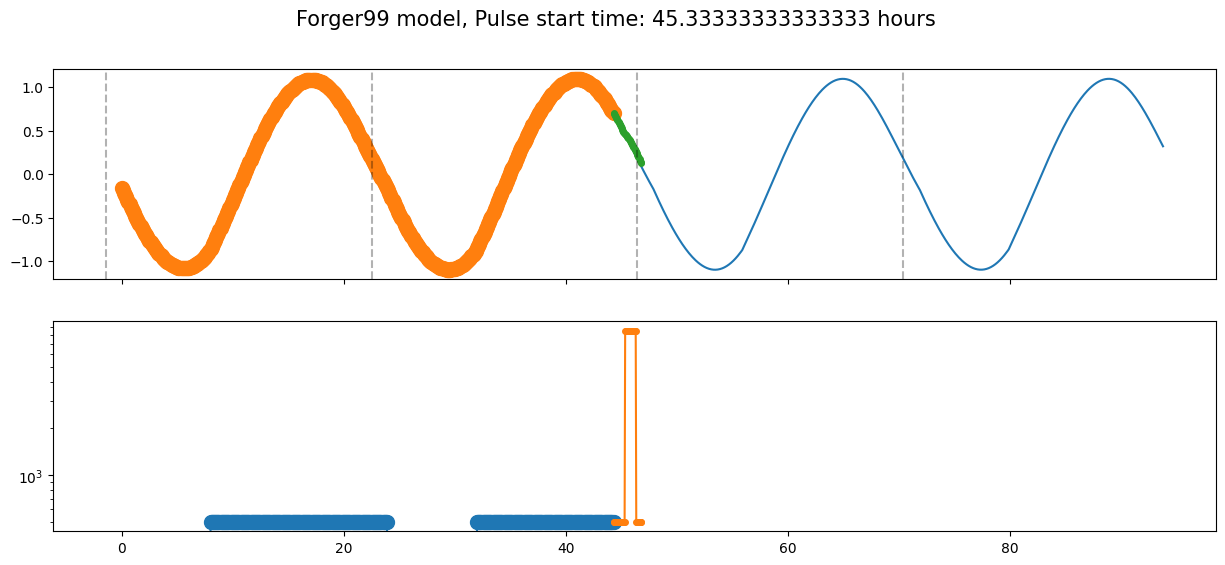

In [20]:
pulse_index = 8
model = 'Forger99'
trajectory = trajectories[model][str(pulse_index)]
# initial_phase = time - trajectory['control_dlmos'][6]
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(15, 6)
# title
fig.suptitle(f'Forger99 model, Pulse start time: {pulse_start_values[pulse_index]} hours', fontsize=15)
axs[0].plot(trajectory['control'].time, 
            trajectory['control'].states[:,0], label='Control')
axs[0].plot(trajectory['pulse_first_part'].time, 
            trajectory['pulse_first_part'].states[:,0], label='Pulse first sim', marker='o', markersize=10)
axs[0].plot(trajectory['pulse_second_part'].time, 
            trajectory['pulse_second_part'].states[:,0], label='Pulse first sim', marker='o', markersize=4)
# plot dlmos as vertical dashed lines
for dlmo in trajectory['control_dlmos']:
    axs[0].axvline(x=dlmo, color='black', linestyle='--', alpha=0.3)

axs[1].plot(trajectory['pulse_first_part'].time, 
            trajectory['light_first_part'], label='Light', marker='o', markersize=10)
axs[1].plot(trajectory['pulse_second_part'].time, 
            trajectory['light_second_part'], label='Light', marker='o', markersize=4)
axs[1].set_yscale('log')

pulse_mid_time = pulse_start_values[pulse_index] + pulse_duration/2
# axs[1].set_xlim(pulse_mid_time - 2.5, pulse_mid_time + 2.5)
plt.show()

## TEST

In [10]:
colors = {
    'Forger99': 'lightseagreen',
    'Jewett99': 'lightseagreen',
    'Hannay19': 'blueviolet',
    'Hannay19TP': 'blueviolet',
}
linestyles = {
    'Forger99': '-',
    'Jewett99': '--',
    'Hannay19': '-',
    'Hannay19TP': '--',
}
phase_shift_offset = 0.0

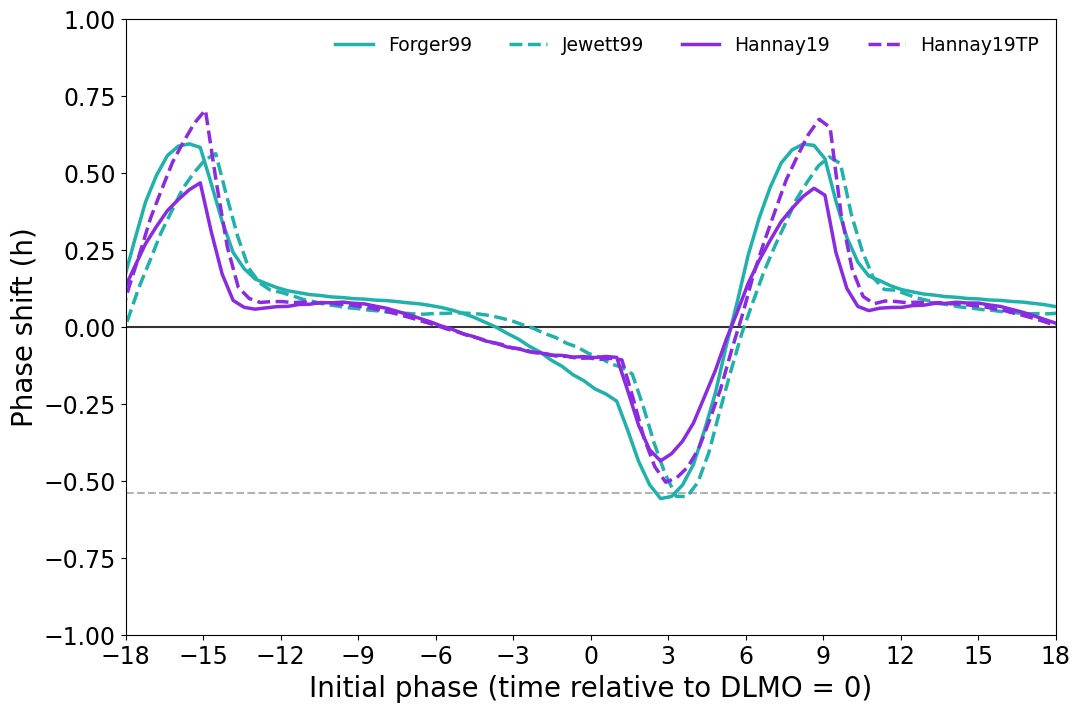

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# simulation results
for idx,model in enumerate(model_list):
    x = []
    y = simulation_result[str(model)]['phase_response'] - phase_shift_offset
    # calculate the initial phase
    for pulse_index in range(pulse_num):
        pulse_start = pulse_start_values[pulse_index]
        pulse_mid_time = pulse_start + pulse_duration/2
        dlmo = simulation_result[str(model)]['reference_dlmo']
        x.append(pulse_mid_time - dlmo)
    plt.plot(x, y, label=str(model), lw=2.5,
             color=colors[str(model)], linestyle=linestyles[str(model)])
# styling
plt.axhline(y=0, color='black', zorder=0, alpha=0.8)
plt.axhline(y=-0.54, color='black', linestyle='--', zorder=0, alpha=0.3)
plt.xlabel('Initial phase (time relative to DLMO = 0)', fontsize=20)
plt.ylabel('Phase shift (h)', fontsize=20)
plt.xlim(-18, 18)
plt.ylim(-1, 1)
plt.xticks(np.linspace(-18, 18, 13), fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=13.5, frameon=False, ncol=5)
plt.show()

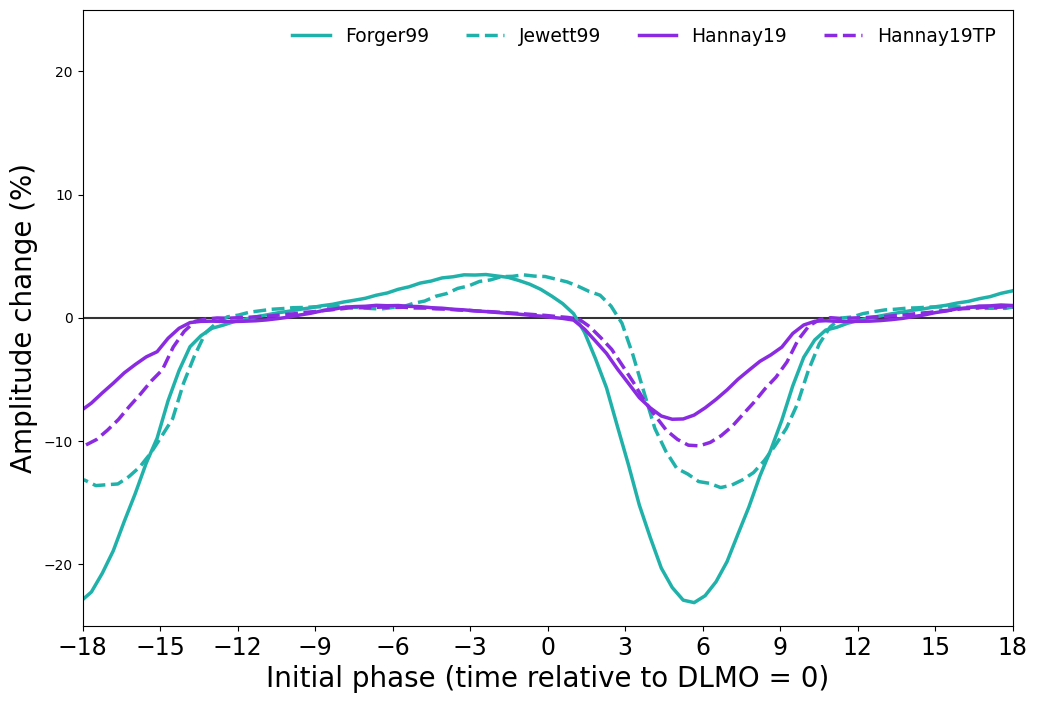

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# simulation results
for idx,model in enumerate(model_list):
    x = []
    y = simulation_result[str(model)]['amplitude_response']
    # calculate the initial phase
    for pulse_index in range(pulse_num):
        pulse_start = pulse_start_values[pulse_index]
        pulse_mid_time = pulse_start + pulse_duration/2
        dlmo = simulation_result[str(model)]['reference_dlmo']
        x.append(pulse_mid_time - dlmo)
    plt.plot(x, y, label=str(model), lw=2.5,
             color=colors[str(model)], linestyle=linestyles[str(model)])
# styling
plt.axhline(y=0, color='black', zorder=0, alpha=0.8)
plt.xlabel('Initial phase (time relative to DLMO = 0)', fontsize=20)
plt.ylabel('Amplitude change (%)', fontsize=20)
plt.xlim(-18, 18)
plt.ylim(-25, 25)
plt.xticks(np.linspace(-18, 18, 13), fontsize=17)
# plt.yticks(np.linspace(-25, 25, 6), fontsize=17)
plt.legend(fontsize=13.5, frameon=False, ncol=5)
plt.show()